In [6]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')
import os.path
import pickle


import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, mean_squared_error

from technicalSignals import Indicators




# #CPU RUN
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [7]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,50)]
kind_of_dataset = 'AffectiveSpace'
NN_INPUT_DIM = 717

In [8]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)
#             price['AARON_30'] = Indicators.aaron(price,30)
#             price['AARON_50'] = Indicators.aaron(price, 50)
#             price['AARON_100'] = Indicators.aaron(price, 100)
#             price['AARON_150'] = Indicators.aaron(price, 150)
#             price['MACD_30_10'] = Indicators.MACD(price, 30,10)
#             price['MACD_50_30'] = Indicators.MACD(price, 50,30)
#             price['MACD_100_50'] = Indicators.MACD(price, 100,50)
#             price['MACD_150_75'] = Indicators.MACD(price, 150,75)
            

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                                  'SMA_30','SMA_50','SMA_100','SMA_150',
                                  'in_BBands', 'eccessVolumes']
            #'AARON_30', 'AARON_50', 'AARON_100', 'AARON_150','MACD_30_10', 'MACD_50_30', 'MACD_100_50','MACD_150_75'] 
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
       #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def normalize(self, values):
        m = min(values)
        M = max(values)
        values = 2*(values-m)/(M-m)-1
        return values


In [9]:
def weighted_MSE(y_true, y_pred):
    weights = K.pow(y_true,2)
    m = K.min(weights)
    M = K.max(weights)
    weights = (weights-m)/(M-m)
    return  K.mean(K.pow(y_true - y_pred, 2)*weights)

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout))
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) OFFICIAL
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return model

def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,y_pred,y_test,l2,drop,n_units):
    f, axarr = plt.subplots(2)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(y_test,'g', label='y_test')
    axarr[0].plot(y_pred,'r', label='y_pred')
    axarr[1].semilogy(history.history['loss'],'g--',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r--',label='loss_val')
    axarr[1].semilogy(history.history['val_weighted_MSE'],'b:',label='loss_val_WITH_W')
    axarr[1].semilogy(history.history['weighted_MSE'],'g:',label='loss_WITH_W')
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show()
    print('Min val loss: ', min(history.history['val_loss']))
    print('Val loss: ', history.history['val_loss'][-1])
            
            
def cv(x_tv,y_tv):
    max_norm_space=[3, 5, 10, 30]
    drop_space=[0.5]
    n_unit_space=[4, 8, 16, 32]
    best_mse = float(np.inf)
    best_l2 = 0
    best_drop = 0
    best_n_units = 0
    best_epochs = 0
    for l2 in max_norm_space:
        for drop in drop_space:
            for n_units in n_unit_space:
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMSE = 0
                nn_model = buildNN2(n_expected_active_units=n_units, dropout = drop, max_norm_val = l2)
                epochs = 0
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    weights = np.power(y_train,2)
                    m = min(weights)
                    M = max(weights)
                    weights = (weights-m)/(M-m)
                    history = nn_model.fit(x_train, y_train, epochs = 1000,batch_size =256, verbose=0, 
                                           validation_data=(x_val, y_val),shuffle=True,
                                           sample_weight = weights)
                    mse = min(history.history['val_weighted_MSE'])
                    epochs = max(np.argmin(history.history['val_weighted_MSE']),500)
                    y_pred = nn_model.predict(x_val, batch_size=256, verbose=0)
                    cvMSE += mse/4
                    reset_weights(nn_model)
                if(cvMSE < best_mse):
                    best_mse = cvMSE
                    best_l2 = l2
                    best_drop = drop
                    best_n_units = n_units
                    best_epochs = epochs
                
    return (best_l2,best_drop,best_n_units,best_epochs)






==================== AAPL ==================== 



trend:  1   50
................(30, 0.5, 4, 500)
==== Test ===


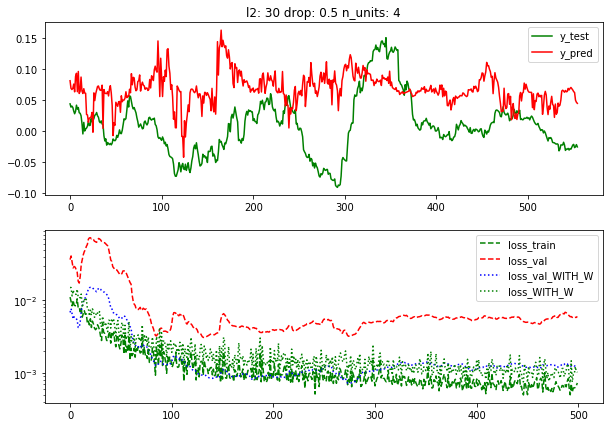

Min val loss:  0.003073952673422592
Val loss:  0.0060056570187412405



==================== AMZN ==================== 



trend:  1   50
................(5, 0.5, 32, 500)
==== Test ===


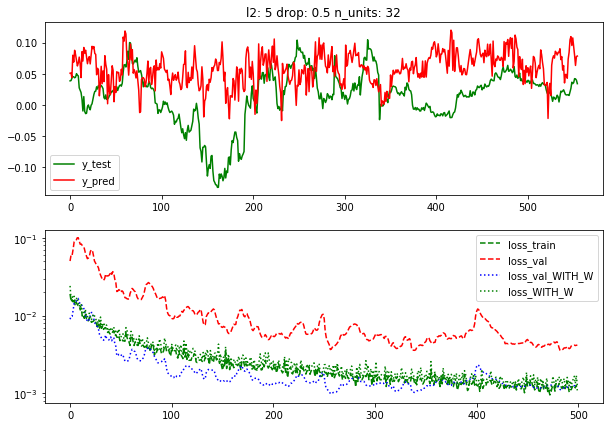

Min val loss:  0.0035348528717132704
Val loss:  0.0041724223450564585



==================== GOOGL ==================== 



trend:  1   50
................(10, 0.5, 4, 500)
==== Test ===


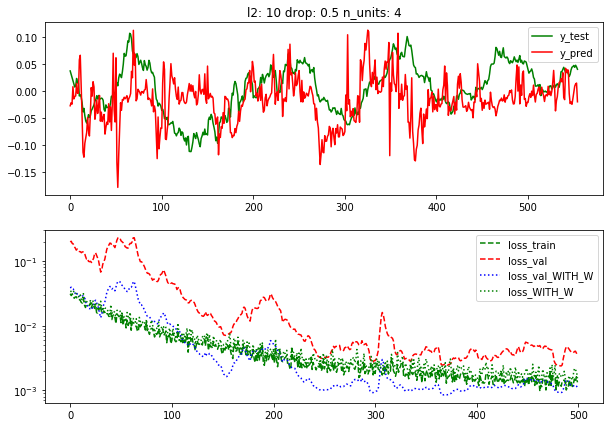

Min val loss:  0.0023878366630818056
Val loss:  0.0034569527916106825



==================== MSFT ==================== 



trend:  1   50
................(3, 0.5, 32, 500)
==== Test ===


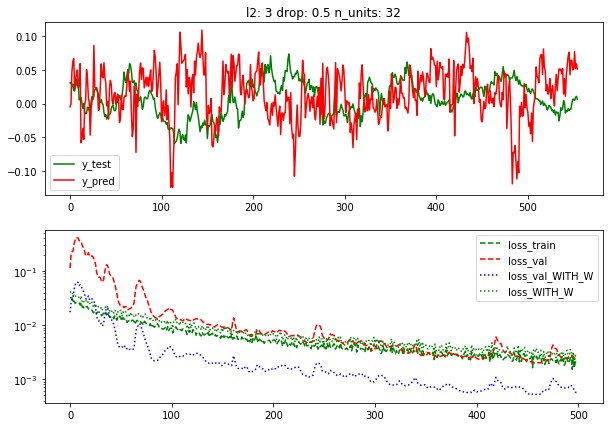

Min val loss:  0.0019849009195191634
Val loss:  0.0023967978724924563



==================== FB ==================== 



trend:  1   50
................(5, 0.5, 16, 754)
==== Test ===


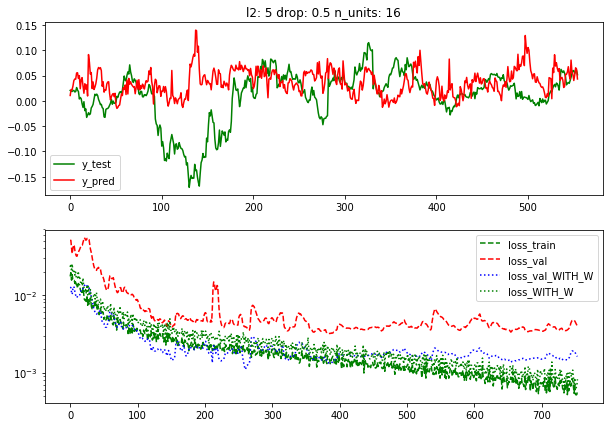

Min val loss:  0.0031733872285028835
Val loss:  0.004091534439604394



==================== INTC ==================== 



trend:  1   50
................(30, 0.5, 8, 991)
==== Test ===


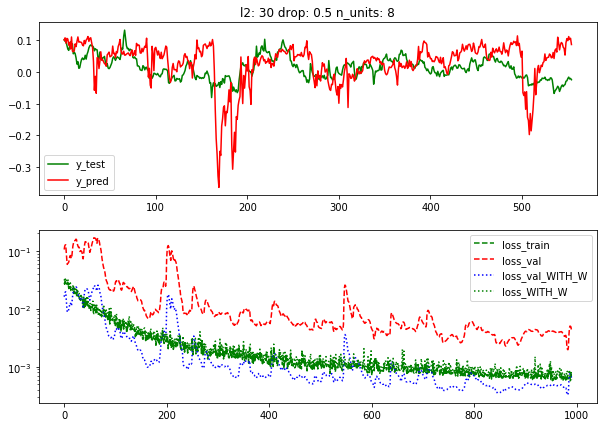

Min val loss:  0.0019654264472223617
Val loss:  0.004289647352856559



==================== CSCO ==================== 



trend:  1   50
................(30, 0.5, 8, 500)
==== Test ===


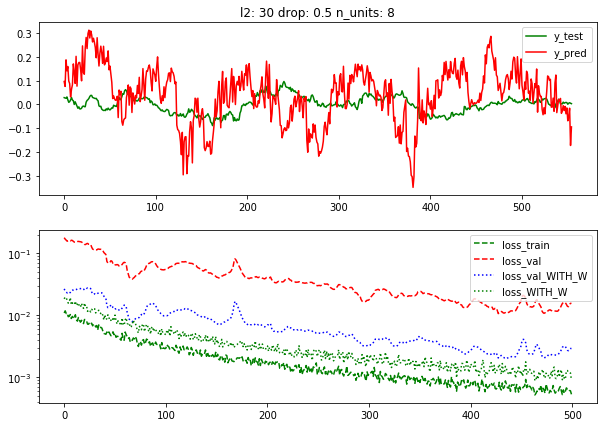

Min val loss:  0.010660742004695642
Val loss:  0.015672747548333966



==================== CMCSA ==================== 



trend:  1   50
................(30, 0.5, 16, 774)
==== Test ===


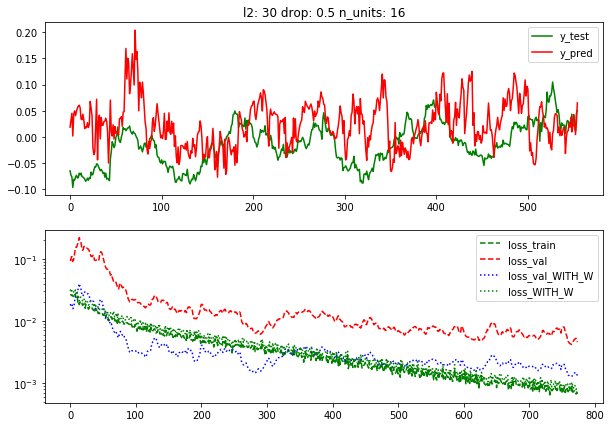

Min val loss:  0.004178582034115722
Val loss:  0.004532472575125327



==================== NVDA ==================== 



trend:  1   50
................(30, 0.5, 16, 500)
==== Test ===


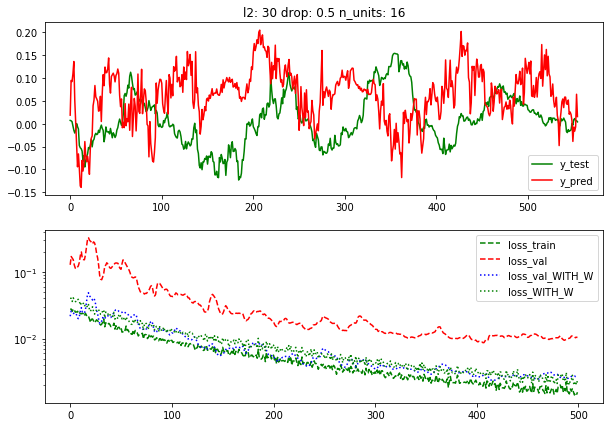

Min val loss:  0.008686551745343316
Val loss:  0.010409190439459709



==================== NFLX ==================== 



trend:  1   50
................(30, 0.5, 32, 500)
==== Test ===


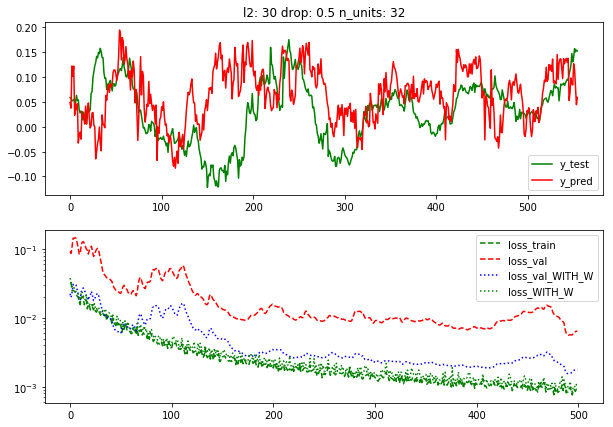

Min val loss:  0.005605780712102313
Val loss:  0.006367873250683015


In [10]:
# TRAINING
#Load results stored
if(os.path.isfile('model_selection_info.pickle')):
    with open('model_selection_info.pickle', 'rb') as handle:
        model_selection_results = pickle.load(handle)
else:
    model_selection_results = {}

for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)
    
    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        (x_tv,y_tv),(x_test,y_test),_ = ds.get_dataset_for_trend(init, finish)


        if (init, finish,ticker) in model_selection_results:
            (best_l2,best_drop,best_n_units,best_epochs) = model_selection_results[(init, finish,ticker)]
        else:
            (best_l2,best_drop,best_n_units,best_epochs) = cv(x_tv,y_tv)
            model_selection_results[(init, finish,ticker)] = (best_l2,best_drop,best_n_units,best_epochs)

        print((best_l2,best_drop,best_n_units,best_epochs))
        nn_model = buildNN2(n_expected_active_units=best_n_units, dropout = best_drop, max_norm_val = best_l2)
        weights = np.power(y_tv, 2)
        m = min(weights)
        M = max(weights)
        weights = (weights-m)/(M-m)
        history = nn_model.fit(x_tv, y_tv, epochs = best_epochs, batch_size =256, verbose=0,
                               validation_data=(x_test, y_test),shuffle=True, sample_weight = weights)
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        print('==== Test ===')
        plot_hystory(history,y_pred,y_test,best_l2,best_drop,best_n_units)  
        model_json = nn_model.to_json()
        with open("pretraining_weights/nn_model_"+str(init)+"_"+str(finish)+"_"+str(ticker)+".json", "w") as json_file:
            json_file.write(model_json)
        nn_model.save_weights('pretraining_weights/nn_model_pretrained_weights_all_tickers_REGR_'+str(init)+'_'+str(finish)+'_'+str(ticker)+'.h5') 

        with open('model_selection_info.pickle', 'wb') as handle:
            pickle.dump(model_selection_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
#TESTING
from keras.models import model_from_json

def get_pretrained_model(init, finish, ticker):
    json_file = open('pretraining_weights/nn_model_'+str(init)+'_'+str(finish)+'_'+str(ticker)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    nn_model.load_weights('pretraining_weights/nn_model_pretrained_weights_all_tickers_REGR_'+str(init)+'_'+str(finish)+'_'+str(ticker)+'.h5')
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    nn_model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return nn_model

for ticker in tickers:
    for (init, finish) in TREND_WINDOWs:
        print('\n\n\n==================== ',ticker,' trend: ',init,' ',finish, ' ==================== \n\n')
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        _,(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        nn_model = get_pretrained_model(init, finish,ticker)
        
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        np.savetxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', y_pred, delimiter=",")





====================  AAPL  trend:  1   50  ==================== 





====================  AMZN  trend:  1   50  ==================== 





====================  GOOGL  trend:  1   50  ==================== 





====================  MSFT  trend:  1   50  ==================== 





====================  FB  trend:  1   50  ==================== 





====================  INTC  trend:  1   50  ==================== 





====================  CSCO  trend:  1   50  ==================== 





====================  CMCSA  trend:  1   50  ==================== 





====================  NVDA  trend:  1   50  ==================== 





====================  NFLX  trend:  1   50  ==================== 




AAPL   1   50


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AMZN   1   50
GOOGL   1   50
MSFT   1   50
FB   1   50
INTC   1   50
CSCO   1   50
CMCSA   1   50
NVDA   1   50
NFLX   1   50


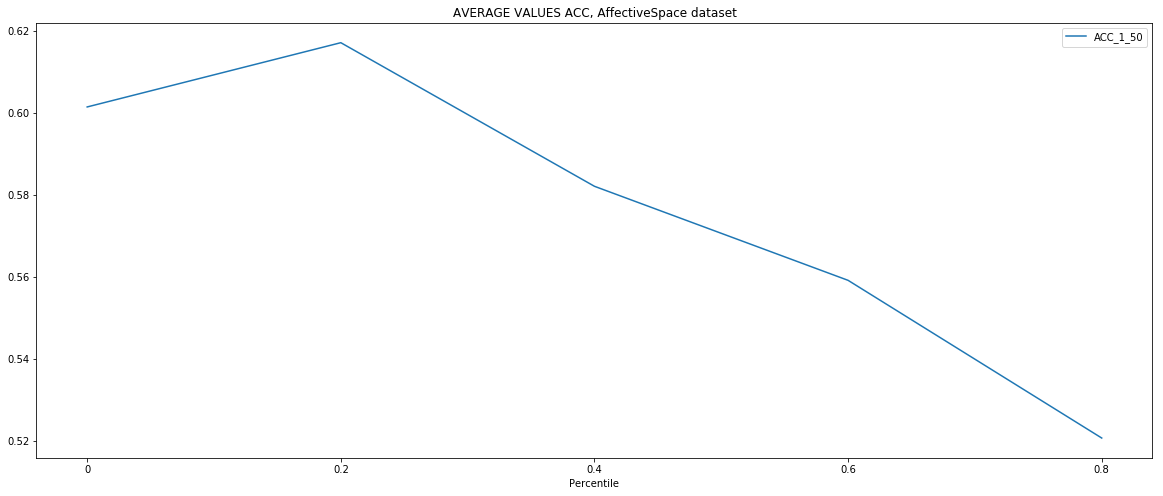

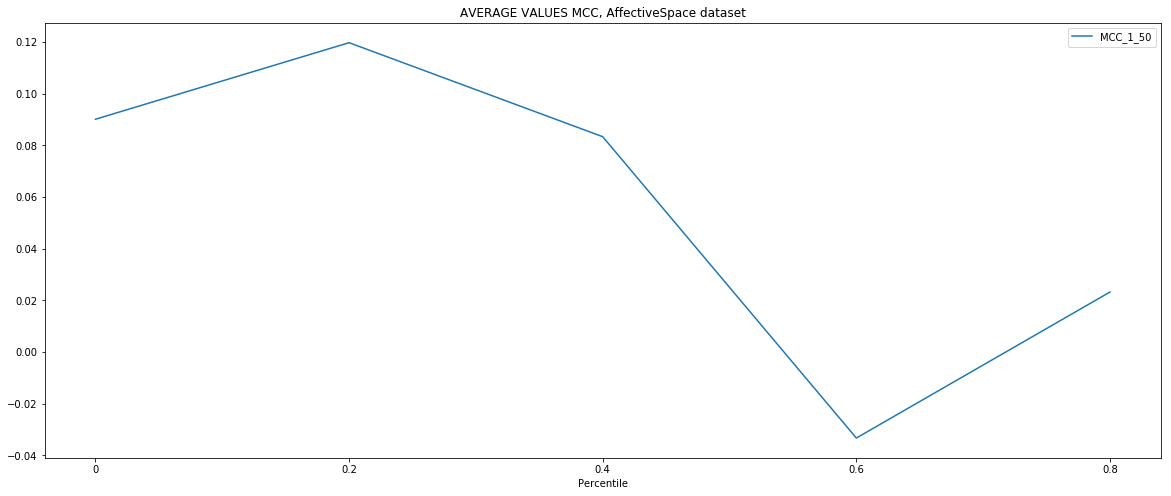

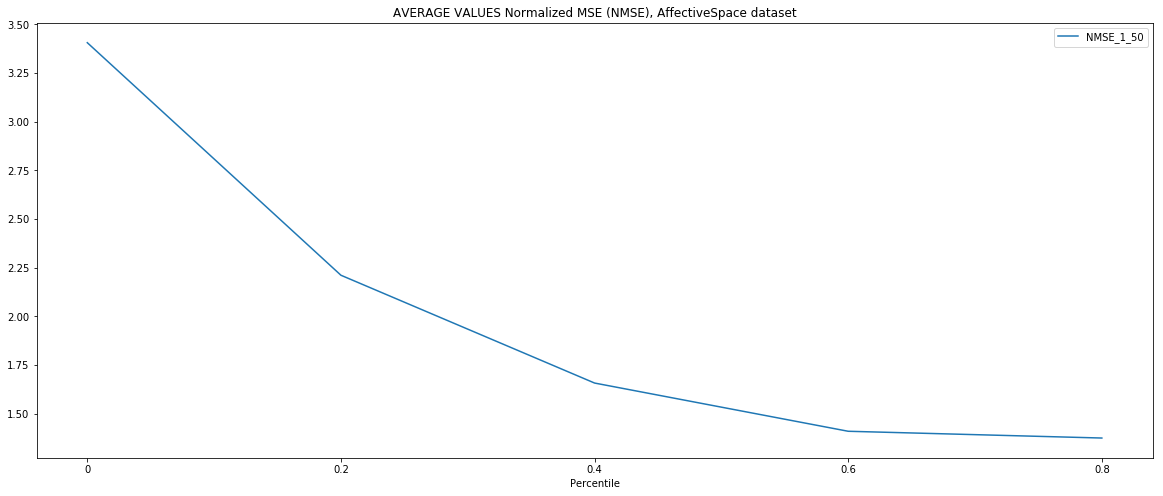

In [18]:
#Predictions Percentile on fluctuations
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        
        thresholds = np.linspace(0, max(np.absolute(y_test)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            weights_over_th = []
            for y, y_p, w in zip(y_test, y_pred, weights):
                if(abs(y)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
                    weights_over_th.append(w)
            mse_w = MSE(y_over_th,y_pred_over_th, sample_weight = weights_over_th)
            mse = MSE(y_over_th,y_pred_over_th)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            MSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mse/len(tickers)
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            MSEs_avg_weight[FUTURE_WINDOWs.index((init, finish)), t]+= mse_w/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8)) 
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 

np.savetxt('NMSE_percentile_on_fluctuations.csv', NMSEs_avg, delimiter=",")
np.savetxt('ACC_percentile_on_fluctuations.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_fluctuations.csv', MCCs_avg, delimiter=",")